<a href="https://colab.research.google.com/github/geoworldlook/F1_predict_model/blob/prediction_2024/prediction_GRAND_PRIX_QATAR_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Section

This cell imports necessary libraries for data processing, model building, and visualization, including pandas, numpy, TensorFlow for the LSTM model, and Matplotlib for plotting.


In [87]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os

### Sequence Length Mapping

This cell defines a dictionary that maps each driver to a specific sequence length. The sequence length is important for adjusting the input data when creating sequences for the LSTM model.


In [88]:
seq_length_map = {
    'VER': 3,
    'NOR': 5,
    'PER': 2,
    'LEC': 3,
    'PIA': 3,
    'RUS': 3,
    'HAM': 5,
    'SAI': 3
}

today_gp = "QATAR"

### Predicting Full Race Times Function

This function is responsible for predicting the full race lap times based on the training data provided. It uses an LSTM model to predict lap times for the given sequence length and handles missing laps by extending the predictions.


In [89]:
import numpy as np
import pandas as pd

def predict_full_race_times_manual(new_train_data, seq_length, total_laps, model):
    """
    Predicts full race lap times based on training data and ensures the prediction
    covers exactly the total_laps specified.

    Args:
        new_train_data (pd.DataFrame): Training data containing 'driver_id' column.
        seq_length (int): Sequence length used for creating sequences.
        total_laps (int): Total number of laps in the race.
        model: Trained model to predict lap times.

    Returns:
        np.ndarray: Predicted race lap times for all laps.
    """
    # Remove the 'driver_id' column if present
    X_new_train_data = new_train_data.drop(['driver_id'], axis=1)

    # Create sequences from the training data
    X_new_train_seq = create_sequences(X_new_train_data, seq_length)

    # Predict the laps for the existing training data
    predicted_race_times = model.predict(X_new_train_seq).flatten()

    # Ensure that the predictions cover all laps (including missing ones)
    missing_laps = total_laps - len(predicted_race_times)

    # Get the last sequence from the training data for generating future laps
    last_sequence = X_new_train_seq[-1]

    # Predict missing laps iteratively, using the last predicted sequence
    for _ in range(missing_laps):
        # Predict the next lap time using the last sequence
        next_lap_time = model.predict(last_sequence[np.newaxis, :, :])[0][0]

        # Append the predicted lap time to the results
        predicted_race_times = np.append(predicted_race_times, next_lap_time)

        # Update the last sequence with the new lap time (autoregressive process)
        last_sequence = np.vstack([last_sequence[1:], np.full((1, last_sequence.shape[1]), next_lap_time)])

    # Ensure the predicted lap times array has exactly total_laps entries
    return predicted_race_times[:total_laps]

def create_sequences(data, seq_length):
    """
    Create sequences for the model input from the given data.

    Args:
        data (pd.DataFrame or np.ndarray): Input data to create sequences from.
        seq_length (int): Length of the sequence for the model.

    Returns:
        np.ndarray: Sequences of data.
    """
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)


### Outlier Removal Function

This function removes outliers from the race lap times. If outliers are detected, they are replaced with the mean of adjacent values or the first five values if available. The outlier threshold is customizable.


In [90]:
def remove_outliers(data, threshold=2):
    """
    Removes outliers from data.

    Args:
        data (np.ndarray): Data to analyze for outliers.
        threshold (float): Threshold for outliers (multiple of standard deviation).

    Returns:
        np.ndarray: Data after outliers are removed, with values replaced by the mean.
    """
    mean = np.mean(data)
    std_dev = np.std(data)

    outliers = np.abs(data - mean) > threshold * std_dev
    filtered_data = data.copy()

    for i in range(len(data)):
        if outliers[i]:
            if i == 0 and len(data) >= 5:
                filtered_data[i] = np.mean(data[:5])
            elif i == len(data) - 1:
                filtered_data[i] = np.mean(data[-5:])
            else:
                filtered_data[i] = (data[i-1] + data[i+1]) / 2

    return filtered_data


### Kalman Filter Function

This function applies a Kalman filter to smooth the predicted lap times. The filter reduces measurement noise and adjusts predictions using the process model variance and measurement noise variance.


In [91]:
def kalman_filter(predictions, Q=1e-5, R=0.1**2):
    """
    Applies a Kalman filter to predicted lap times to smooth the data.

    Args:
        predictions (np.ndarray): Predicted lap times.
        Q (float): Process model variance.
        R (float): Measurement noise variance.

    Returns:
        np.ndarray: Smoothed lap times after applying the Kalman filter.
    """
    n = len(predictions)
    xhat = np.zeros(n)
    P = np.zeros(n)
    xhat[0] = predictions[0]
    P[0] = 1.0

    for k in range(1, n):
        xhatminus = xhat[k-1]
        Pminus = P[k-1] + Q
        K = Pminus / (Pminus + R)
        xhat[k] = xhatminus + K * (predictions[k] - xhatminus)
        P[k] = (1 - K) * Pminus

    return xhat


### Error Statistics Calculation Function

This function calculates and displays error metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and R-squared (R2). It helps assess the accuracy of the model's predictions.


In [92]:
def calculate_error_stats(real_times, predicted_times):
    """
    Calculates error statistics for the predicted race times.

    Args:
        real_times (np.ndarray): Actual race lap times.
        predicted_times (np.ndarray): Predicted race lap times.

    Returns:
        tuple: Contains calculated statistics: MAE, MSE, RMSE, MAPE, R2.
    """
    mae = mean_absolute_error(real_times, predicted_times)
    mse = mean_squared_error(real_times, predicted_times)
    rmse = mse ** 0.5
    mape = np.mean(np.abs((real_times - predicted_times) / real_times)) * 100
    r2 = r2_score(real_times, predicted_times)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-squared (R2): {r2:.2f}")

    return mae, mse, rmse, mape, r2


### Data Rescaling Function

This function is used to reverse the scaling applied to the data, restoring it to its original scale using a MinMaxScaler. This is important to visualize and analyze the results in real-world units (lap times).


In [93]:
def inverse_scale_data(scaler, data, column_name):
    """
    Restores original values from scaled data using StandardScaler.

    Args:
        scaler (StandardScaler): StandardScaler object that scaled the data.
        data (np.ndarray): Scaled data.
        column_name (str): The name of the column for which the data is being rescaled.

    Returns:
        np.ndarray: Original values after inverse scaling.
    """
    column_index = scaler.feature_names_in_.tolist().index(column_name)
    column_scaler = StandardScaler()
    column_scaler.mean_ = scaler.mean_[column_index]
    column_scaler.scale_ = scaler.scale_[column_index]
    return column_scaler.inverse_transform(data.reshape(-1, 1)).flatten()


## Sequence Creation Function

The `create_sequences` function generates sequences of data for time series forecasting. It slices the dataset into overlapping sequences of length `seq_length`, which is a hyperparameter to be tuned.


In [94]:
def create_sequences(data, seq_length):
    """
    Converts data into sequences for LSTM models.

    Parameters:
    data (array-like): The input data to be converted into sequences.
    seq_length (int): The length of each sequence.

    Returns:
    np.array: The data converted into sequences.
    """
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)


In [95]:
def save_prediction_data_for_driver(driver, predicted_times, filename):
    """
    Saves prediction data for a specific driver to a CSV file.

    Args:
        driver (str): The driver's ID.
        predicted_times (np.ndarray): The predicted lap times.
        filename (str): The name of the CSV file to save the data to.
    """

    data = {'Lap': list(range(1, len(predicted_times) + 1)),
            'PredictedLapTime': predicted_times}
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

### Visualization Section

This section generates plots comparing the predicted lap times with the real lap times and also displays the smoothed data from the Kalman filter. The plots help to visually analyze the performance of the model.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Folder already exists at: /content/drive/MyDrive/F1_MODEL/PREDICTION/2024/QATAR
(57,)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


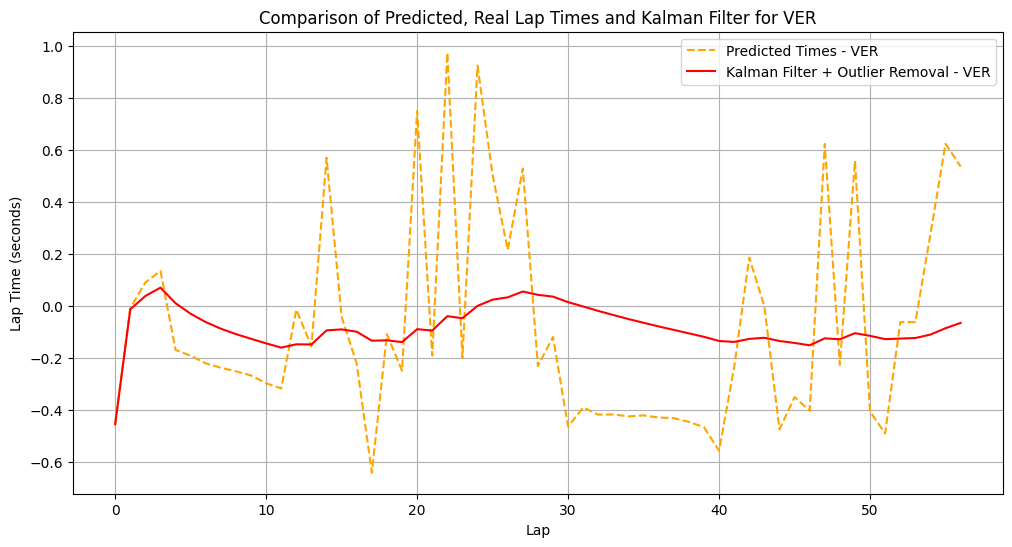

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Folder already exists at: /content/drive/MyDrive/F1_MODEL/PREDICTION/2024/QATAR
(57,)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


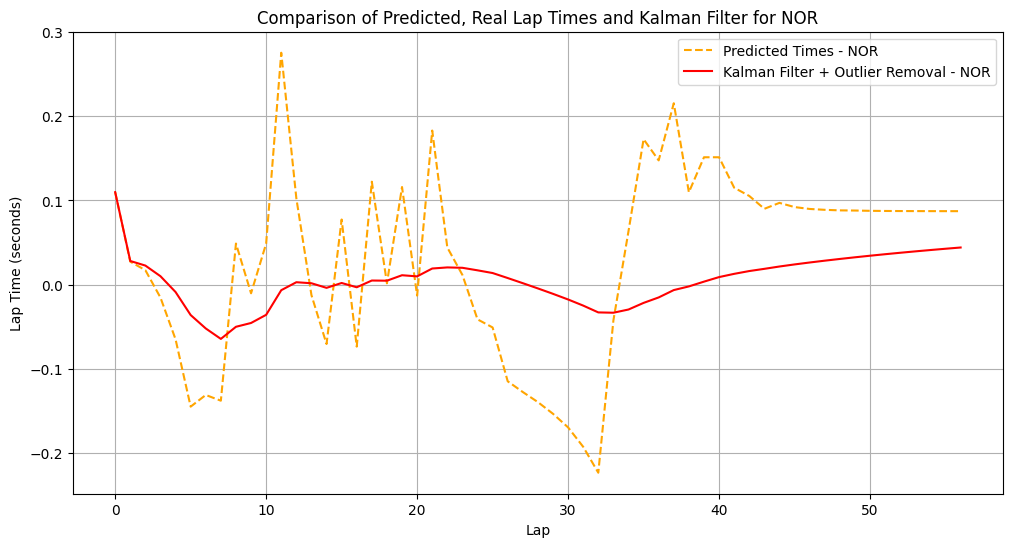

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Folder already exists at: /content/drive/MyDrive/F1_MODEL/PREDICTION/2024/QATAR
(57,)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


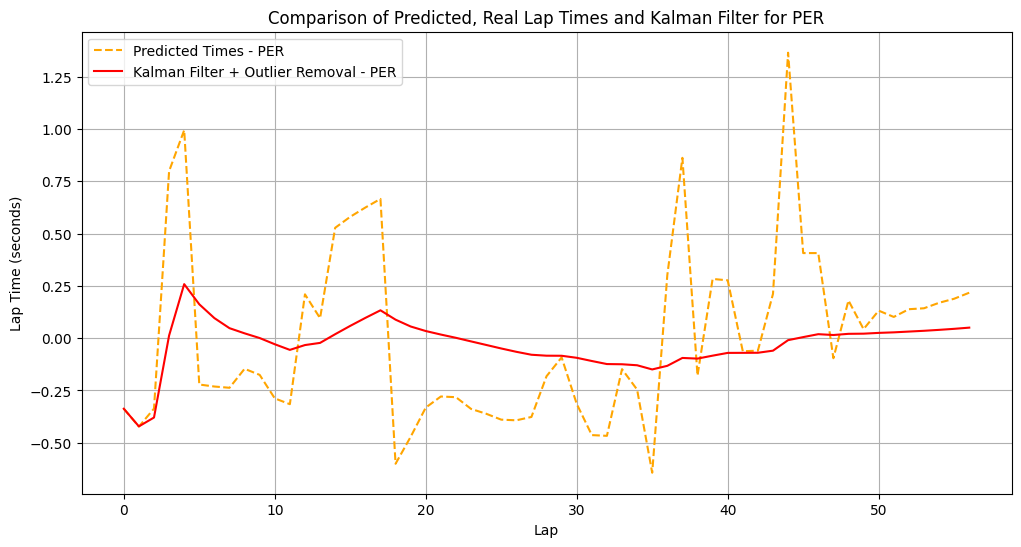

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Folder already exists at: /content/drive/MyDrive/F1_MODEL/PREDICTION/2024/QATAR
(57,)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


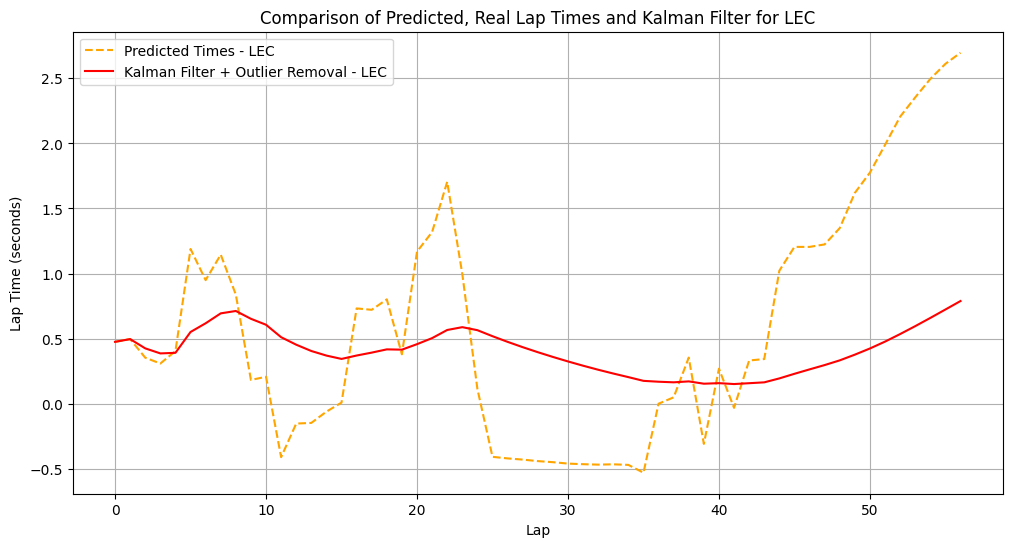

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Folder already exists at: /content/drive/MyDrive/F1_MODEL/PREDICTION/2024/QATAR
(57,)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


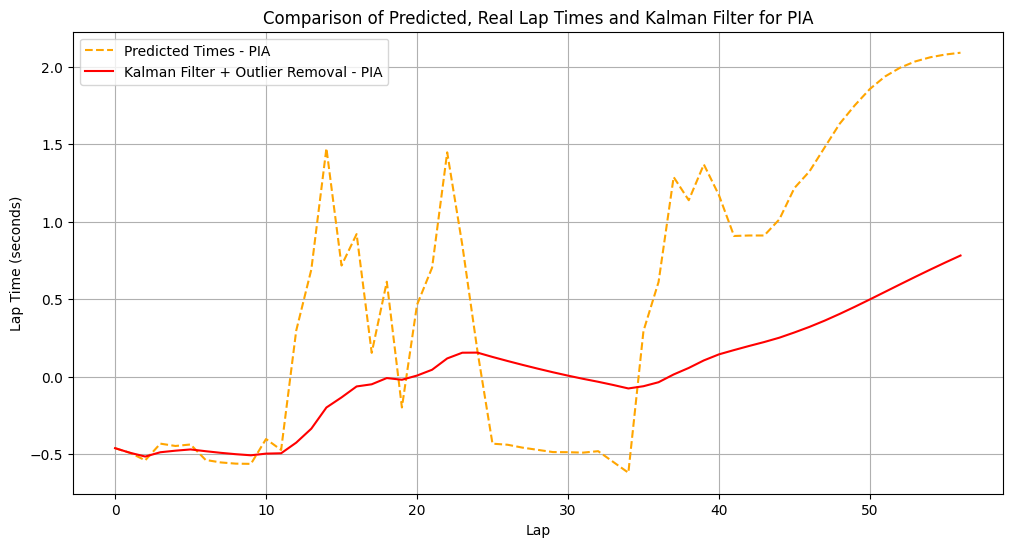

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Folder already exists at: /content/drive/MyDrive/F1_MODEL/PREDICTION/2024/QATAR
(57,)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


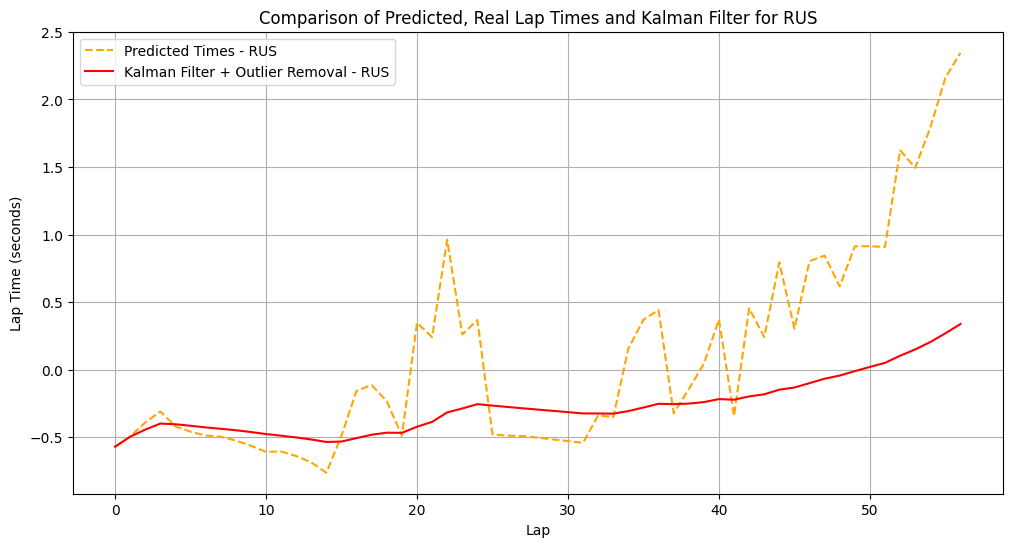

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Folder already exists at: /content/drive/MyDrive/F1_MODEL/PREDICTION/2024/QATAR
(57,)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


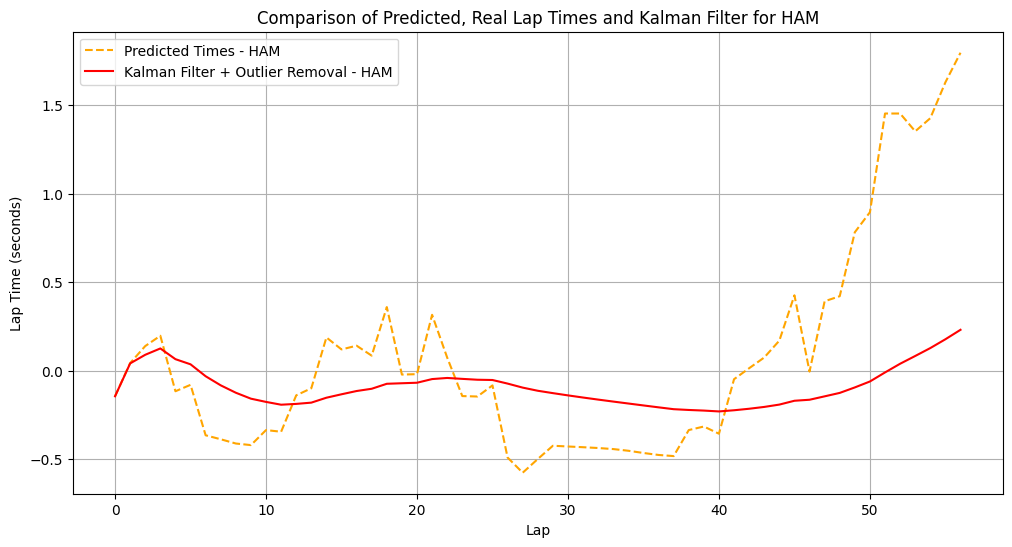

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Folder already exists at: /content/drive/MyDrive/F1_MODEL/PREDICTION/2024/QATAR
(57,)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


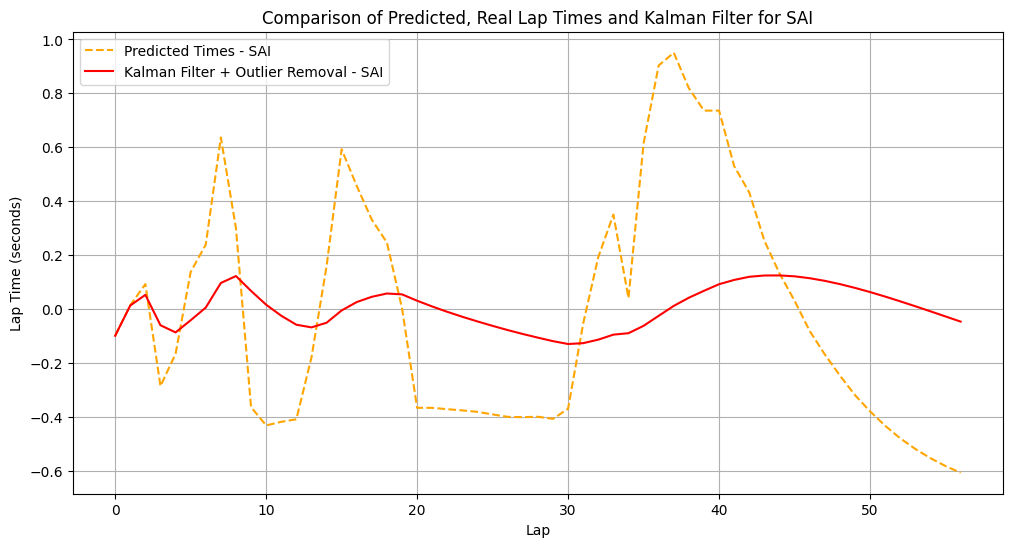

In [96]:
import matplotlib.pyplot as plt
import os

# List of drivers and sequence lengths for prediction
driver_list = ['VER', 'NOR', 'PER', 'LEC', 'PIA', 'RUS', 'HAM','SAI']
# Model performance metrics to evaluate (e.g., mean squared error)
model_parametr_objective = ['mean_squared_error']

# List to store predicted total times for each driver
predicted_times_list = []
real_times_list = []

# Total number of laps for the race (example: 62 laps for a specific race)
total_laps = 57

# Loop over each type of objective (e.g., 'mean_squared_error') for evaluation
for type_objective in model_parametr_objective:

    # Loop through each driver in the list to load their respective models
    for driver in driver_list:

        # Load the trained model for the specific driver and objective metric
        model = tf.keras.models.load_model(f"/content/drive/MyDrive/F1_MODEL/with_points/2022_2024/model_v3/model_trained_with_best_hyperparams_and_race_data_{driver}_{type_objective}_points_huber.h5")

        # Load the training data for the driver, containing lap times for FP1, FP2, FP3, and qualifying sessions
        new_train_data = pd.read_csv(f"/content/drive/MyDrive/F1_MODEL/with_points/2022_2024/DATA_{today_gp}_2024/{today_gp}_2024_fp1_fp2_fp3_q_points_fp1_fp2_fp3_q_{driver}.csv")

        #make a folder
        folder_path = f"/content/drive/MyDrive/F1_MODEL/PREDICTION/2024/{today_gp}"


        # Retrieve the sequence length for the driver's model (this value is predefined)
        seq_length = seq_length_map[driver]

        # Predict lap times for the entire race (all laps) based on training data

        ####Blad wynikajacy z danych, nie wiem dlaczego indexy są
        #new_train_data = new_train_data.drop(['Unnamed: 0'], axis=1)

        predicted_times = predict_full_race_times_manual(new_train_data, seq_length, total_laps,model)

        # Apply the Kalman filter to the predicted lap times for noise reduction and outlier removal
        filtered_times_kalman = kalman_filter(predicted_times)

        # Load the scaler to inverse scale the predicted lap times back to the original time format (seconds)
        scaler = joblib.load(f"/content/drive/MyDrive/F1_MODEL/with_points/2022_2024/DATA_{today_gp}_2024/scaler_points.pkl")

        # Inverse transform the filtered predicted times to return to the original lap time scale (seconds)
        original_predicted_times = inverse_scale_data(scaler, filtered_times_kalman, 'LapTime_seconds')

        try:
          os.makedirs(folder_path)
          print(f"Folder created successfully at: {folder_path}")
        except FileExistsError:
          print(f"Folder already exists at: {folder_path}")


        save_prediction_data_for_driver(driver, original_predicted_times, f"{folder_path}/predict_{today_gp}_{driver}.csv")
        print(original_predicted_times.shape)
        # Add the sum of predicted lap times to the list for later comparison
        predicted_times_list.append(np.sum(original_predicted_times))

        # Plot the comparison between predicted times and Kalman-filtered times
        plt.figure(figsize=(12, 6))  # Define the figure size for the plot
        plt.plot(predicted_times, linestyle='--', label=f'Predicted Times - {driver}', color='orange')  # Plot predicted times
        plt.plot(filtered_times_kalman, linestyle='-', label=f'Kalman Filter + Outlier Removal - {driver}', color='red')  # Plot filtered times

        # Label the x-axis as 'Lap' and y-axis as 'Lap Time (seconds)'
        plt.xlabel('Lap')
        plt.ylabel('Lap Time (seconds)')

        # Set the title for the plot with the driver's name
        plt.title(f'Comparison of Predicted, Real Lap Times and Kalman Filter for {driver}')

        # Display a legend and enable the grid for better readability
        plt.legend()
        plt.grid(True)

        # Show the plot
        plt.show()




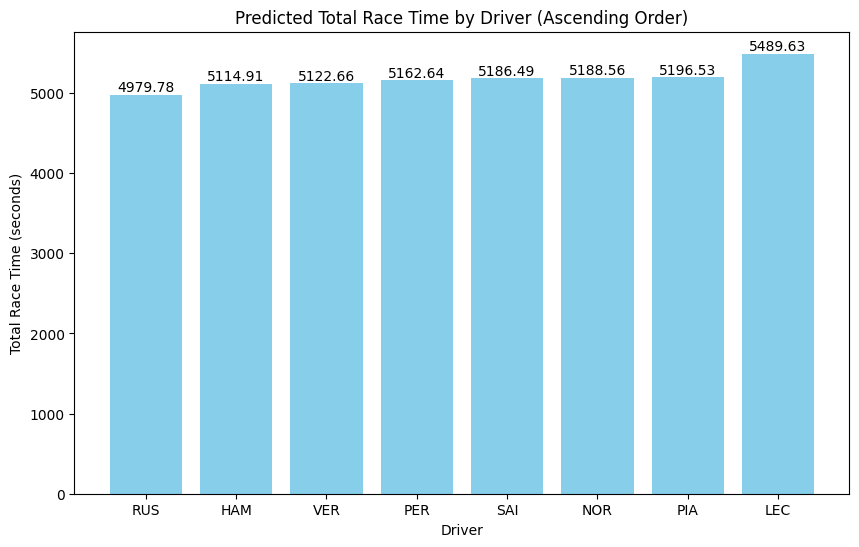

In [97]:
# Sort predicted_times_list and driver_list in ascending order based on predicted_times_list
sorted_data = sorted(zip(predicted_times_list, driver_list))
predicted_times_list_sorted, driver_list_sorted = zip(*sorted_data)

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(driver_list_sorted, predicted_times_list_sorted, color='skyblue')
plt.title('Predicted Total Race Time by Driver (Ascending Order)')
plt.xlabel('Driver')
plt.ylabel('Total Race Time (seconds)')

# Add the sum above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.show()

# Weekend Summary

* RUS starts from Pole Position and Mercedes has good weekend. They were the fastest in the all sessions at the weekend
* HAM made 2 mistake in his Q3 laps, so he will started from P10
* SAI better managed the tires in Q3 and was faster than LEC
* Ferrari have good pace
* RedBull have to much downforce in rear, they modificed rear wing on the track
* Mclaren will start from P6 and P8 (PIA). NOR is overrated in model.
* PER start from P16
* VER from P5
* From P3 GAS in Alpine

---

## Conclusions and Predictions

* SAI or RUS will win the race
* Ferrari on podium
* VER in top 5


---

## Comprare with real result after the race



In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def pad_data_with_zeros(data, target_length):
    """
    Pads data with zeros to match the target length.

    Parameters:
    data (array-like): The input data to be padded.
    target_length (int): The target length after padding.

    Returns:
    np.array: Data padded with zeros to match the target length.
    """
    if len(data) < target_length:
        padding = np.zeros(target_length - len(data))
        return np.concatenate([data, padding])
    return data

def calculate_error_stats(real_times, predicted_times):
    """
    Calculates and prints error statistics (MAE, MSE, RMSE) between real and predicted lap times,
    ignoring zero values in real_times and removing outliers.

    Parameters:
    real_times (array-like): The actual lap times.
    predicted_times (array-like): The predicted lap times.

    Returns:
    tuple: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE).
    """
    # Ignore zero values in real lap times
    mask = real_times != 0
    filtered_real_times = real_times[mask]
    filtered_predicted_times = predicted_times[mask]

    # Remove outliers from the real lap times
    filtered_real_times = remove_outliers(filtered_real_times)

    # Adjust the lengths of the data after outlier removal
    min_length = min(len(filtered_real_times), len(filtered_predicted_times))
    filtered_real_times = filtered_real_times[:min_length]
    filtered_predicted_times = filtered_predicted_times[:min_length]

    # Calculate error statistics
    mae = np.mean(np.abs(filtered_real_times - filtered_predicted_times))
    mse = np.mean((filtered_real_times - filtered_predicted_times) ** 2)
    rmse = np.sqrt(mse)

    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

    return mae, mse, rmse

# List of drivers
driver_list = ['VER', 'NOR', 'PER', 'LEC', 'PIA', 'RUS', 'HAM','SAI']

# File path variables (to save space)
base_prediction_path = f"/content/drive/MyDrive/F1_MODEL/PREDICTION/2024/{today_gp}"
base_real_path = f"/content/drive/MyDrive/F1_MODEL/PREDICTION/2024/{today_gp}/REAL_RESULT"

for driver in driver_list:
    # Load predicted and real data
    predicted_data = pd.read_csv(f"{base_prediction_path}/predict_{today_gp}_{driver}.csv")
    real_data = pd.read_csv(f"{base_real_path}/lap_times_{driver}.csv")
    real_data = real_data.fillna(0)

    # Match the lengths of the data (pad with zeros)
    target_length = max(len(real_data), len(predicted_data))
    real_data_lap_times = pad_data_with_zeros(real_data['LapTime_seconds'].values, target_length)
    predicted_lap_times = pad_data_with_zeros(predicted_data['PredictedLapTime'].values, target_length)

    # Calculate error statistics
    print('______________________________________________________________________________')
    print(f"Driver: {driver}")
    calculate_error_stats(real_data_lap_times, predicted_lap_times)
    print('______________________________________________________________________________')

    # Plot comparison graph
    plt.figure(figsize=(12, 6))
    plt.plot(predicted_lap_times, linestyle='--', label=f'Predicted Times - {driver}', color='orange')
    plt.plot(real_data_lap_times, label=f'Real Times - {driver}', color='blue')
    plt.xlabel('Lap')
    plt.ylabel('Lap Time (seconds)')
    plt.title(f'Comparison of Predicted and Real Lap Times for {driver}')
    plt.legend()
    plt.grid(True)
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/F1_MODEL/PREDICTION/2024/QATAR/REAL_RESULT/lap_times_VER.csv'

### Weekend Summary







